In [5]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.linalg import svd
from tqdm import tqdm

In [62]:
def WNNM(img, patchSize, c, K, delta, sigma, nThreshold):
    windowSize = 3 * patchSize
    pad=windowSize
    paddedImg = np.pad(img, pad_width=pad, mode='constant')
    numberOfIt = 3
    x_hat = img
    total_iterations = K * (paddedImg.shape[0] - 2 * windowSize) * (paddedImg.shape[1] - 2 * windowSize)
    with tqdm(total=total_iterations, desc="Processing") as pbar:
        for n in range(K):
            x_hat=np.pad(x_hat,pad_width=pad)
            y_hat = x_hat + delta * (paddedImg - x_hat)
            pixel_contribution_matrix = np.ones_like(paddedImg)
            for i in range(windowSize, paddedImg.shape[0] - windowSize):
                for j in range(windowSize, paddedImg.shape[1] - windowSize):
                    window = y_hat[i - windowSize:i + windowSize + 1, j - windowSize: j + windowSize + 1]
                    mainPatch = y_hat[i - patchSize:i + patchSize + 1, j - patchSize: j + patchSize + 1]
                    distances = []
                    similarPatchMatrix = np.zeros([(2 * patchSize + 1) ** 2, (2 * (windowSize - patchSize) + 1) ** 2])
                    idx = 0
                    for k in range(patchSize, window.shape[0] - patchSize):
                        for l in range(patchSize, window.shape[1] - patchSize):
                            similarPatch = window[k - patchSize:k + patchSize + 1, l - patchSize:l + patchSize + 1]
                            distance = np.sum((mainPatch - similarPatch) ** 2)
                            distances.append(distance)
                            similarPatchMatrix[:, idx] = similarPatch.flatten()
                            idx += 1
                    min_indices = np.argsort(distances)[:nThreshold]
                    Yj = similarPatchMatrix[:, min_indices]
                    U, S, V_T = svd(Yj, full_matrices=False)
                    sing_val = np.sqrt(np.maximum(S ** 2 - nThreshold * sigma ** 2, 0))
                    for m in range(numberOfIt):
                        w = c * np.sqrt(nThreshold) / (sing_val + 10 ** (-6))
                        sing_val = np.diag(np.maximum(S - w, 0))
                    Xj_hat = U @ np.diag(np.maximum(S - w, 0)) @ V_T
                    x_patch = np.clip(Xj_hat[:, 0].reshape((2 * patchSize + 1, 2 * patchSize + 1)), 0, 1)
                    x_hat[i - patchSize:i + patchSize + 1, j - patchSize: j + patchSize + 1] += x_patch
                    mainPatchRegion = (i - patchSize, i + patchSize + 1, j - patchSize, j + patchSize + 1)
                    pixel_contribution_matrix[mainPatchRegion[0]:mainPatchRegion[1], mainPatchRegion[2]:mainPatchRegion[3]] += 1
                    pbar.update(1)
    
            x_hat = x_hat[pad:-pad, pad:-pad]
    
            pixel_contribution_matrix = pixel_contribution_matrix[pad:-pad, pad:-pad]
            x_hat=x_hat / pixel_contribution_matrix
    
    return x_hat



Processing: 100%|██████████| 30000/30000 [02:22<00:00, 210.71it/s]


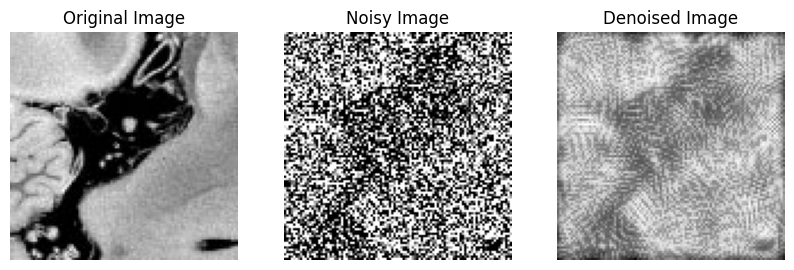

In [63]:
img = cv.imread('Low Matrix Approximation question.jpg', 0) / 255
patchSize = 3
delta = 0.1
c = 2.8
K = 3
sigma = 1
nThreshold = 50
# Add noise to the image
noisy_img = img + np.random.normal(loc=0, scale=1, size=img.shape)

# Clip the values to ensure they remain in the valid range [0, 1]
noisy_img = np.clip(noisy_img, 0, 1)

# Denoise the image using the WNNM function
denoised_img = WNNM(noisy_img[300:400,300:400], patchSize, c, K, delta, sigma, nThreshold)

# Display the original, noisy, and denoised images
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(img[300:400,300:400], cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_img[300:400,300:400], cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_img, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.show()
